In [0]:
import sys


import pandas as pd #collection of functions for data processing and analysis 
import matplotlib #collection of functions for scientific  visualization

from collections import Counter
import numpy as np #package for scientific computing

import matplotlib.pyplot as plt

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
df = pd.read_csv('combined_data.csv',encoding = "ISO-8859-1")
df.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(162455, 8)

In [0]:
df=df[['File', 'Import', 'Account', 'Year', 'Month', 'Tag']]
df=df[['File', 'Tag']]

In [0]:
df.head()

,File,Tag
0,\Clients\A-D\Carter's Home Improvement LLC\Acc...,Tax
1,\Clients\A-D\Carter's Home Improvement LLC\Acc...,Tax
2,\Clients\A-D\Carter's Home Improvement LLC\Acc...,Tax
3,\Clients\A-D\Carter's Home Improvement LLC\Acc...,Statements
4,\Clients\A-D\Carter's Home Improvement LLC\Acc...,Statements


In [0]:
df.dtypes

File    object
Tag     object
dtype: object

In [0]:
df.isnull().sum()

File       0
Tag     3518
dtype: int64

In [0]:
df_notnull=df[df.Tag.notnull()]
df_null=df[pd.isnull(df['Tag'])]

In [0]:
df.shape
df_notnull.shape
# df_null.shape

(158937, 2)

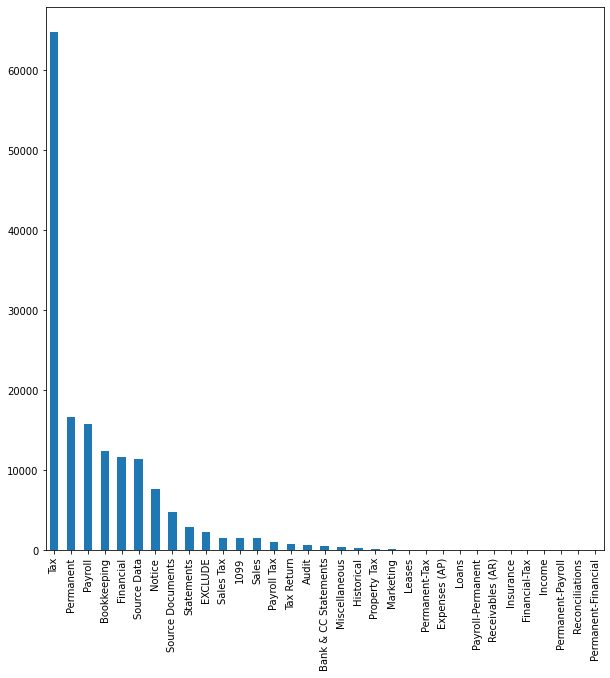

In [0]:
fig = plt.figure(figsize=(10, 10))

df_notnull['Tag'].value_counts().plot.bar()

In [0]:
df_notnull['Tag'].value_counts()

Tax                     64731
Permanent               16690
Payroll                 15719
Bookkeeping             12417
Financial               11682
Source Data             11355
Notice                   7677
Source Documents         4806
Statements               2890
EXCLUDE                  2262
Sales Tax                1537
1099                     1513
Sales                    1472
Payroll Tax              1056
Tax Return                774
Audit                     605
Bank & CC Statements      474
Miscellaneous             412
Historical                324
Property Tax              182
Marketing                 150
Leases                     81
Permanent-Tax              46
Expenses (AP)              26
Loans                      26
Payroll-Permanent          14
Receivables (AR)            3
Insurance                   3
Financial-Tax               3
Income                      3
Permanent-Payroll           2
Reconciliations             1
Permanent-Financial         1
Name: Tag,

In [0]:
df_notnull=df_notnull.loc[(df_notnull['Tag'] != 'Reconciliations') & (df_notnull['Tag']!= 'Permanent-Financial')]

In [0]:
df_notnull.shape



(158935, 2)

In [0]:
# removing Reconciliations and Permanent-Financial 



## Preprocessing 


In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text =text.lower() # lowercase text
    text=text.replace('\\'," ")
    text=text.replace('/'," ")
    text=text.replace("-", " ")
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df_notnull['File'] = df_notnull['File'].apply(clean_text)

In [0]:
df_notnull['File'][0]

'clients carters home improvement llc accounting services 2018 2018 1099 copy 1 cpdf'

In [0]:
df_notnull['File'].apply(lambda x: len(x.split(' '))).sum()

#~1.8 Million words

1832421

In [0]:
X = df_notnull['File']
y = df_notnull['Tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42,stratify=y)

In [0]:
tags=y.unique()

In [0]:
print(len(tags))

31



Vectorization:
TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator. vocabulary_ Is a dictionary that converts each token (word) to feature index in the matrix

In [0]:
#naive bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=tags))
print(classification_report(y_test, y_pred))

accuracy 0.9015956108118991


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

                1099       1.00      0.34      0.50       378
               Audit       1.00      0.02      0.04       151
Bank & CC Statements       1.00      0.89      0.94       119
         Bookkeeping       0.87      0.99      0.93      3104
             EXCLUDE       1.00      0.46      0.63       566
       Expenses (AP)       0.00      0.00      0.00         6
           Financial       0.93      0.91      0.92      2921
       Financial-Tax       0.00      0.00      0.00         1
          Historical       1.00      0.74      0.85        81
              Income       0.00      0.00      0.00         1
           Insurance       0.00      0.00      0.00         1
              Leases       1.00      0.05      0.10        20
               Loans       0.00      0.00      0.00         6
           Marketing       0.95      1.00      0.97        37
       Miscellaneous       0.98      0.56      0.72       103
       

In [0]:
#linear SVM

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9157145014345397


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

                1099       0.97      0.49      0.65       378
               Audit       1.00      0.02      0.04       151
Bank & CC Statements       0.99      0.97      0.98       119
         Bookkeeping       0.91      0.95      0.93      3104
             EXCLUDE       0.91      0.68      0.78       566
       Expenses (AP)       0.00      0.00      0.00         6
           Financial       0.93      0.87      0.90      2921
       Financial-Tax       0.00      0.00      0.00         1
          Historical       1.00      0.74      0.85        81
              Income       0.00      0.00      0.00         1
           Insurance       0.00      0.00      0.00         1
              Leases       0.89      0.40      0.55        20
               Loans       0.00      0.00      0.00         6
           Marketing       0.95      1.00      0.97        37
       Miscellaneous       0.96      0.43      0.59       103
       

In [0]:
# from sklearn.svm import SVC
# sgd = Pipeline([('vect', CountVectorizer()),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', SVC(C=10,kernel='rbf'))])


# sgd.fit(X_train, y_train)

# y_pred = sgd.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.05, max_depth= 4, n_estimators=100,min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt'))])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7558262445260986


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

                1099       0.76      0.44      0.56       378
               Audit       0.91      0.76      0.83       151
Bank & CC Statements       0.87      0.79      0.83       119
         Bookkeeping       0.94      0.68      0.79      3104
             EXCLUDE       0.89      0.64      0.75       566
       Expenses (AP)       0.67      0.67      0.67         6
           Financial       0.93      0.42      0.58      2921
       Financial-Tax       1.00      1.00      1.00         1
          Historical       0.90      1.00      0.95        81
              Income       0.00      0.00      0.00         1
           Insurance       0.00      0.00      0.00         1
              Leases       0.68      0.85      0.76        20
               Loans       0.60      0.50      0.55         6
           Marketing       0.89      0.89      0.89        37
       Miscellaneous       0.67      0.62      0.65       103
       

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.9940605023405648


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

                1099       0.99      0.98      0.99       378
               Audit       0.98      0.98      0.98       151
Bank & CC Statements       1.00      1.00      1.00       119
         Bookkeeping       1.00      1.00      1.00      3104
             EXCLUDE       0.99      1.00      0.99       566
       Expenses (AP)       1.00      0.83      0.91         6
           Financial       0.99      0.99      0.99      2921
       Financial-Tax       1.00      1.00      1.00         1
          Historical       0.94      1.00      0.97        81
              Income       1.00      1.00      1.00         1
           Insurance       1.00      1.00      1.00         1
              Leases       0.95      1.00      0.98        20
               Loans       1.00      1.00      1.00         6
           Marketing       0.97      1.00      0.99        37
       Miscellaneous       0.99      0.88      0.93       103
       